In [1]:
import os
import openslide
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
import cv2
import staintools

In [2]:
carpeta_base = './GDCdata/'

# StainGAN

In [3]:
# Comprobamos si existe la carpeta Normalizadas, sino crearla
carpeta_normalizadas = os.path.join(carpeta_base, "Normalizadas")
os.makedirs(carpeta_normalizadas, exist_ok=True)

# Leer todas las imágenes .svs y guardarlas en un array
carpetas = []
archivos_final = []
imagenes_svs = []
imagenes_np = []
for carpeta, subcarpetas, archivos in os.walk(carpeta_base):
    for archivo in archivos:
        archivo_save = archivo.replace('.','-',1).split('.')[0]
        archivos_final.append(archivo_save)
        if archivo.endswith('.svs'):
            ruta_imagen = os.path.join(carpeta, archivo)
            imagenes_svs.append(ruta_imagen)
            carpetas.append(carpeta)
            slide = openslide.OpenSlide(ruta_imagen)
            nivel = 1  # Cambia esto si necesitas otro nivel de detalle
            dimensiones = slide.level_dimensions[nivel]
            imagen_np = np.array(slide.read_region((0, 0), level=nivel, size=dimensiones))[:, :, :3]

            # Guardar la imagen en la lista
            imagenes_np.append(imagen_np)


In [4]:
# Redimensionar las imágenes
## Encontrar la máxima altura y anchura
max_alto = max(img.shape[0] for img in imagenes_np)
max_ancho = max(img.shape[1] for img in imagenes_np)

## Redimensionar todas las imágenes al tamaño mínimo
imagenes_np_resized = [cv2.resize(img, (max_ancho, max_alto)) for img in imagenes_np]

In [5]:
# Calcular el promedio cromático global
promedio_global = np.zeros_like(imagenes_np_resized[0], dtype=np.float32)
for imagen in imagenes_np_resized:
    promedio_global += imagen / len(imagenes_np_resized)

promedio_global = np.uint8(promedio_global)  # Convertir a uint8

# Crear y ajustar el normalizador con la referencia global
normalizador = staintools.ReinhardColorNormalizer()
# normalizador = staintools.ReinhardNormalizer()
normalizador.fit(promedio_global)

In [6]:
imagenes_normalizadas = []
ruta_imagenes_normalizadas = []
for i, imagen in enumerate(imagenes_np_resized):
    imagen_normalizada = normalizador.transform(imagen)
    imagenes_normalizadas.append(imagen_normalizada)

    # Obtener nombre original sin extensión
    nombre_original = os.path.splitext(os.path.basename(imagenes_svs[i]))[0]
    nombre_archivo_normalizado = f"{nombre_original}_normalizada.png"

    # Definir ruta de guardado
    ruta_guardado = os.path.join(carpeta_normalizadas, nombre_archivo_normalizado)
    ruta_imagenes_normalizadas.append(ruta_guardado)

    # Guardar imagen normalizada
    imagen_pil = Image.fromarray(imagen_normalizada)
    imagen_pil.save(ruta_guardado)

    print(f"Imagen normalizada guardada en: {ruta_guardado}")

Imagen normalizada guardada en: ./GDCdata/Normalizadas/TCGA-55-8091-01Z-00-DX1.0996c58a-6e93-4092-8cb8-014d548fe60c_normalizada.png
Imagen normalizada guardada en: ./GDCdata/Normalizadas/TCGA-J2-A4AE-01Z-00-DX1.42C5DE4A-7787-4E59-8969-D12503262C96_normalizada.png
Imagen normalizada guardada en: ./GDCdata/Normalizadas/TCGA-NK-A5CT-01A-03-TSC.A38F3C8C-403F-4D23-A16D-43FD6764E764_normalizada.png
Imagen normalizada guardada en: ./GDCdata/Normalizadas/TCGA-92-8064-01Z-00-DX1.72c1a8db-146c-4408-8d31-43baba769fdf_normalizada.png


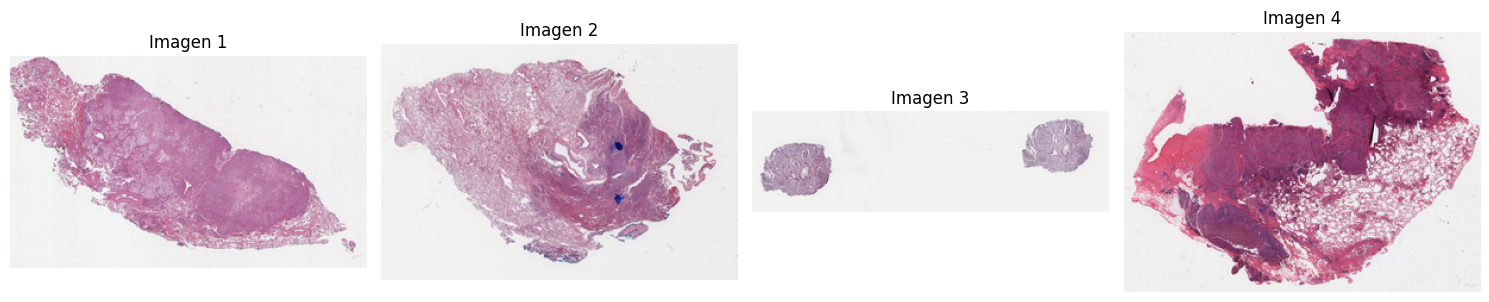

In [7]:
thumbnail_size = (300, 300)
plt.figure(figsize=(15, 10))
for i, ruta in enumerate(imagenes_svs):
    slide = openslide.OpenSlide(ruta)
    thumbnail = slide.get_thumbnail(thumbnail_size)  # Crear miniatura

    imagen_np = np.array(thumbnail)  # Convertir a NumPy array

    # Agregar subplot para cada imagen
    plt.subplot(1, len(imagenes_svs), i + 1)
    plt.imshow(imagen_np)
    plt.axis("off")  # Ocultar ejes
    plt.title(f"Imagen {i+1}")  # Título

plt.tight_layout()
plt.show()

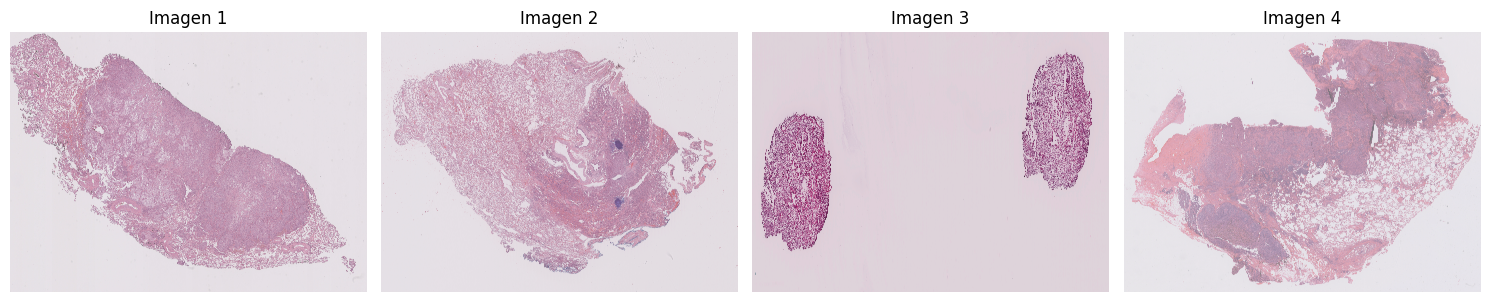

In [9]:
plt.figure(figsize=(15, 10))
Image.MAX_IMAGE_PIXELS = None # Aumentamos el límite de píxeles permitidos

# Iterar sobre las imágenes PNG
for i, ruta in enumerate(ruta_imagenes_normalizadas):
    if not os.path.exists(ruta):
        print(f"Archivo no encontrado: {ruta}")
        continue
    
    imagen = Image.open(ruta)  # Abrir imagen con PIL
    imagen_np = np.array(imagen)  # Convertir a NumPy array

    # Agregar subplot para visualizar
    plt.subplot(1, len(ruta_imagenes_normalizadas), i + 1)
    plt.imshow(imagen_np)
    plt.axis("off")
    plt.title(f"Imagen {i+1}")

# Mostrar imágenes
plt.tight_layout()
plt.show()